In [1]:
import time
start_time = time.time()

In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from MultiTimeframeCandleManager import MultiTimeframeCandleManager
from datetime import datetime, timedelta
import time
from collections import deque
import numpy as np
import copy
import tensorflow as tf
from tqdm import tqdm
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt

candles = obj_load("NQ_1")[600000:]
len(candles)

loading NQ_1


250000

In [3]:
num_actions = 3

In [4]:

lrelu = tf.keras.layers.LeakyReLU(0.05)


chart_m15 = tf.keras.layers.Input(shape = (60,4))
chart_m5 = tf.keras.layers.Input(shape = (60,4))
chart_m1 = tf.keras.layers.Input(shape = (60,4))

pdas = tf.keras.layers.Input(shape = (3*3+3*3+1+12*5+5*3,))

current_position = tf.keras.layers.Input(shape = (3,))

minutes = tf.keras.layers.Input(shape = (1,))
minutes_embed = tf.keras.layers.Embedding(input_dim=60*24, output_dim=8)(minutes)
minutes_embed_flat = tf.keras.layers.Flatten()(minutes_embed)

f15 = tf.keras.layers.Flatten()(chart_m15)
f5 = tf.keras.layers.Flatten()(chart_m5)
f1 = tf.keras.layers.Flatten()(chart_m1)

pdas_repeated = tf.keras.layers.Lambda(
lambda inputs: tf.repeat(tf.expand_dims(inputs, axis = 1), repeats=60, axis=1)
)(pdas)

concatenated_m5_at = tf.keras.layers.Concatenate(axis=-1)([chart_m5, pdas_repeated])
m5_at = tf.keras.layers.Dense(512)(concatenated_m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(256)(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(128)(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.LSTM(512)(m5_at)

concatenated_m1_at = tf.keras.layers.Concatenate(axis=-1)([chart_m1, pdas_repeated])
m1_at = tf.keras.layers.Dense(512)(concatenated_m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(256)(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(128)(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.LSTM(512)(m1_at)


#c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, scaled_open_profit])
c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, m1_at, m5_at])

d = tf.keras.layers.Dense(4096*4)(c)
d = lrelu(d)
d = tf.keras.layers.Dense(4096*4)(d)
d = lrelu(d)
d = tf.keras.layers.Dense(4096*2)(d)
d = lrelu(d)
d = tf.keras.layers.Dense(4096*1)(d)
d = lrelu(d)


value = tf.keras.layers.Dense(1, activation="linear")(d)
advantage = tf.keras.layers.Dense(num_actions, activation="linear")(d)

q_values = tf.keras.layers.Lambda(
lambda inputs: inputs[0] + (inputs[1] - tf.reduce_mean(inputs[1], axis=1, keepdims=True))
)([value, advantage])

outputs = tf.keras.layers.Activation('linear', dtype='float32')(q_values)

model = tf.keras.Model(inputs = [chart_m15, chart_m5, chart_m1, pdas, minutes, current_position], outputs = outputs)


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 94)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 60, 4)]      0           []                               
                                                                                                  
 lambda (Lambda)                (None, 60, 94)       0           ['input_4[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 60, 98)       0           ['input_3[0][0]',                
                                                                  'lambda[0][0]']             

In [5]:
model.load_weights("model.weights.h5")

In [6]:

def relative (value, center, r):
        return (value - center) / r

def ret_to_scaled_inputs(ret):

    midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret


    center = (midnight_opening_range_high + midnight_opening_range_low) / 2
    r = max(0.0001,(midnight_opening_range_high - midnight_opening_range_low) / 2)

    pda_rel = []
    pda_rel.append(relative(midnight_open, center, r))
    for pda in pdas[0:9+9+15]:
        pda_rel.append(relative(pda, center, r))
    for index in range(9+9+15,9+9+15+5*12):
        ## highs lows are like this [h, h_taken, l, l_taken]
        ## the bools should not be scaled
        if (index - 9+9+15) % 2 == 0:
            pda_rel.append(relative(pdas[index], center, r))
        else:
            pda_rel.append(pdas[index])

    pda_np = np.array(pda_rel)

    current_minutes = current_time.hour * 60 + current_time.minute

    charts_array = []
    for candlesticks in charts:
        charts_array.append([])
        for candle in candlesticks:
            o = relative(candle.o, center, r)
            h = relative(candle.h, center, r)
            l = relative(candle.l, center, r)
            c = relative(candle.c, center, r)
            charts_array[-1].append([o,h,l,c])

    m15_np = np.array(charts_array[0])
    m5_np = np.array(charts_array[1])
    m1_np = np.array(charts_array[2])

    return [m15_np, m5_np, m1_np, pda_np, current_minutes]


# In[11]:


class Order:
    def __init__(self, limit, stop, tp, direction):
        self.entry = limit
        self.tp = tp
        self.sl = stop
        self.direction = direction

class Position:
    def __init__(self, entry, stop, tp, direction):
        self.entry = entry
        self.tp = tp
        self.sl = stop
        self.direction = direction


In [7]:
def step(index):

        global current_position, current_order, slm, m, outputs, all_candles, cmm, equity, equity_L
    
        ret = m.push_m1_candle(candles[index])
        midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret
        center = (midnight_opening_range_high + midnight_opening_range_low) / 2
        r = max(0.0001, (midnight_opening_range_high - midnight_opening_range_low) / 2)



        current_candle_m1 = charts[2][-1]
        #### check tp before filling order so that the same m1 candle will not trigger tp - it is not sure if the candle hit first limit and later tp or reve3rse
        if current_position.direction == 1:
            if current_candle_m1.h >= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.l <= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)

        #### check order
        if current_order != None:
            if  current_order.direction == 1:
                if current_candle_m1.l < current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill long order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None
        if current_order != None:
            if  current_order.direction == -1:
                if current_candle_m1.h > current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill short order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None

        #### check sl
        if current_position.direction == 1:
            if current_candle_m1.l <= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.h >= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)




        if(len(m.ndogs) == 5 and len(m.fps) == 3 and len(m.opening_range_gaps) == 3 and len(m.asia_highs_lows) == 3 and len(m.london_highs_lows) == 3 and len(m.ny_am_highs_lows) == 3 and len(m.ny_lunch_highs_lows) == 3 and len(m.ny_pm_highs_lows) == 3):


            open_profit = (current_close - current_position.entry) * current_position.direction

            scaled_entry_diff  =  0
            scaled_sl_diff  =  0
            if(current_position.direction != 0):
                scaled_entry_diff = (current_close - current_position.entry) / r
                scaled_sl_diff = (current_close - current_position.sl) / r

            state = ret_to_scaled_inputs(ret) + [np.array([current_position.direction, scaled_entry_diff, scaled_sl_diff])]
            m15_np, m5_np, m1_np, pda_np, current_minutes, pos_info = state

            equity_L.append(equity+open_profit)
            all_candles.append(charts[2][-1])


            if True:#current_minutes >= 9*60+29 and current_minutes < 16*60:
                output = inference_step(
                    tf.expand_dims(m15_np, 0),
                    tf.expand_dims(m5_np, 0),
                    tf.expand_dims(m1_np, 0),
                    tf.expand_dims(pda_np, 0),
                    tf.expand_dims(current_minutes, 0),
                    tf.expand_dims(pos_info, 0)
                )

                last_action = np.argmax(output)
                outputs.append(output[0])
            else:
                last_action = 2


            avg_candle_range = np.mean([ i.h - i.l for i in list(charts[2])[55:60]])

            if(last_action == 2 and current_position.direction != 0):
                equity += open_profit
                current_position = Position(0,0,0,0)
                #print("close position:", open_profit)

            if(last_action == 0 and current_position.direction == 1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 0 and current_position.direction == 0):
                last_candle_low = charts[2][-2].l
                if ( last_candle_low < current_close ):
                    last_candle_low = None

                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[0] > current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1])
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0])

                if(len(pdas_filtered) > 0):

                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_low[0][0]
                    if(last_candle_low != None):
                        entry = min(entry, last_candle_low)


                    sl = entry + avg_candle_range * slm
                    tp = entry  -  abs(entry-sl) * 1000


                    current_order = Order(entry, sl, tp, -1)
                    #print("set short order:",entry,sl,tp)



            if(last_action == 1 and current_position.direction == -1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 1 and current_position.direction == 0):
                last_candle_high = charts[2][-2].h
                if ( last_candle_high > current_close ):
                    last_candle_high = None
                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[1] < current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1], reverse=True)
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0], reverse=True)

                if(len(pdas_filtered) > 0):
                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_high[0][1]
                    if(last_candle_high != None):
                        entry = max(entry, last_candle_high)

                    sl = entry - avg_candle_range * slm
                    tp = entry  +  abs(entry-sl) * 1000

                    current_order = Order(entry, sl, tp, 1)
                    #print("set long order:",entry,sl,tp)



In [20]:
m = MultiTimeframeCandleManager()

slm = 1.5#1.5

current_position = Position(0,0,0,0)
current_order = None

equity = 0
equity_L = [0]

outputs = []
all_candles = []

cmm = 0.5

@tf.function()
def inference_step(m15_np, m5_np, m1_np, pda_np, current_minutes, pos_info):
    return model([
        m15_np,
        m5_np,
        m1_np,
        pda_np,
        current_minutes,
        pos_info,
    ])



for index in tqdm(range(len(candles))):
    step(index)
    if( index % 100 == 0 ):
        print(equity_L[-1])


  2%|█                                                                        | 3805/250000 [00:00<00:12, 19446.62it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-6.17500000000291
-3.100000000002183


  2%|█▋                                                                         | 5749/250000 [00:06<06:08, 663.06it/s]

-19.225000000002183
-26.200000000000728
-28.025000000001455
-22.624999999996362
-32.25
-50.79999999999927
-83.35000000000218


  3%|█▉                                                                         | 6458/250000 [00:21<21:34, 188.15it/s]

-21.950000000004366
-14.150000000005093
-26.17500000000291
-4.92500000000291
-17.92500000000291
-16.625000000003638


  3%|██▏                                                                        | 7108/250000 [00:35<39:05, 103.55it/s]

-16.625000000003638


  3%|██▏                                                                        | 7113/250000 [00:35<39:19, 102.94it/s]

-20.625000000003638
-23.924999999999272
-29.799999999999272
-26.049999999999272


  3%|██▎                                                                         | 7530/250000 [00:45<52:20, 77.20it/s]

-50.80000000000291
-62.92500000000291


  3%|██▎                                                                         | 7807/250000 [00:51<59:05, 68.30it/s]

-90.97500000000218
-41.450000000004366


  3%|██▎                                                                       | 7995/250000 [00:55<1:03:44, 63.27it/s]

-18.35000000000582
-32.27500000000509


  3%|██▍                                                                       | 8125/250000 [00:58<1:06:39, 60.48it/s]

-32.825000000008004


  3%|██▍                                                                       | 8280/250000 [01:01<1:10:43, 56.96it/s]

-47.075000000004366


  3%|██▍                                                                       | 8404/250000 [01:04<1:15:23, 53.41it/s]

-52.950000000008004


  3%|██▌                                                                       | 8506/250000 [01:06<1:26:15, 46.66it/s]

-44.85000000000946


  3%|██▌                                                                       | 8606/250000 [01:08<1:28:08, 45.65it/s]

-45.85000000000946


  3%|██▌                                                                       | 8706/250000 [01:10<1:39:28, 40.43it/s]

-50.300000000010186


  4%|██▌                                                                       | 8806/250000 [01:13<1:33:53, 42.82it/s]

-52.425000000010186


  4%|██▋                                                                       | 8906/250000 [01:15<1:38:09, 40.94it/s]

-54.925000000010186


  4%|██▋                                                                       | 9006/250000 [01:17<1:30:41, 44.29it/s]

-62.125000000007276


  4%|██▋                                                                       | 9109/250000 [01:20<1:29:01, 45.10it/s]

-69.95000000000437


  4%|██▋                                                                       | 9209/250000 [01:22<1:15:31, 53.14it/s]

-43.65000000000509


  4%|██▊                                                                       | 9305/250000 [01:23<1:14:14, 54.04it/s]

-30.875


  4%|██▊                                                                       | 9403/250000 [01:25<1:45:00, 38.18it/s]

-52.69999999999709


  4%|██▊                                                                       | 9508/250000 [01:28<1:30:08, 44.46it/s]

-55.99999999999636


  4%|██▊                                                                       | 9608/250000 [01:30<1:30:10, 44.43it/s]

-54.924999999991996


  4%|██▊                                                                       | 9703/250000 [01:32<1:31:03, 43.98it/s]

-44.999999999992724


  4%|██▉                                                                       | 9808/250000 [01:35<1:27:51, 45.56it/s]

-54.19999999999345


  4%|██▉                                                                       | 9908/250000 [01:37<1:35:15, 42.01it/s]

-59.34999999999127


  4%|██▉                                                                      | 10008/250000 [01:39<1:26:12, 46.40it/s]

-45.374999999992724


  4%|██▉                                                                      | 10103/250000 [01:41<1:38:44, 40.49it/s]

-67.69999999998981


  4%|██▉                                                                      | 10207/250000 [01:44<1:27:40, 45.59it/s]

-62.59999999999127


  4%|███                                                                      | 10308/250000 [01:46<1:26:09, 46.36it/s]

-55.34999999999127


  4%|███                                                                      | 10408/250000 [01:48<1:27:37, 45.57it/s]

-56.799999999991996


  4%|███                                                                      | 10508/250000 [01:50<1:24:33, 47.20it/s]

-58.47499999999491


  4%|███                                                                      | 10608/250000 [01:53<1:33:17, 42.76it/s]

-78.799999999992


  4%|███▏                                                                     | 10708/250000 [01:55<1:27:09, 45.75it/s]

-73.799999999992


  4%|███▏                                                                     | 10808/250000 [01:57<1:24:38, 47.10it/s]

-78.8499999999949


  4%|███▏                                                                     | 10908/250000 [01:59<1:26:31, 46.05it/s]

-69.77499999999782


  4%|███▏                                                                     | 11008/250000 [02:01<1:28:01, 45.25it/s]

-75.62499999999636


  4%|███▏                                                                     | 11109/250000 [02:04<1:27:02, 45.74it/s]

-81.19999999999709


  4%|███▎                                                                     | 11209/250000 [02:06<1:29:06, 44.66it/s]

-84.32499999999709


  5%|███▎                                                                     | 11309/250000 [02:08<1:31:34, 43.44it/s]

-79.92499999999563


  5%|███▎                                                                     | 11409/250000 [02:10<1:26:19, 46.06it/s]

-70.82499999999345


  5%|███▎                                                                     | 11509/250000 [02:13<1:24:45, 46.90it/s]

-62.07499999999345


  5%|███▍                                                                     | 11609/250000 [02:15<1:26:20, 46.02it/s]

-59.77499999999054


  5%|███▍                                                                     | 11704/250000 [02:17<1:26:12, 46.07it/s]

-69.34999999999127


  5%|███▍                                                                     | 11809/250000 [02:19<1:24:50, 46.79it/s]

-71.799999999992


  5%|███▍                                                                     | 11909/250000 [02:21<1:27:30, 45.35it/s]

20.40000000000873


  5%|███▌                                                                     | 12004/250000 [02:23<1:28:56, 44.60it/s]

-45.89999999999418


  5%|███▌                                                                     | 12109/250000 [02:26<1:23:31, 47.47it/s]

-50.34999999999491


  5%|███▌                                                                     | 12209/250000 [02:28<1:28:13, 44.92it/s]

-63.19999999999345


  5%|███▌                                                                     | 12309/250000 [02:30<1:28:29, 44.77it/s]

-106.02499999999418


  5%|███▌                                                                     | 12409/250000 [02:32<1:27:09, 45.43it/s]

-114.9749999999949


  5%|███▋                                                                     | 12509/250000 [02:35<1:27:18, 45.33it/s]

-112.82499999999345


  5%|███▋                                                                     | 12609/250000 [02:37<1:25:24, 46.32it/s]

-133.99999999999272


  5%|███▋                                                                     | 12709/250000 [02:39<1:30:54, 43.50it/s]

-136.27499999999418


  5%|███▋                                                                     | 12809/250000 [02:41<1:27:52, 44.99it/s]

-128.42499999999563


  5%|███▊                                                                     | 12904/250000 [02:44<1:30:27, 43.69it/s]

-117.0999999999949


  5%|███▊                                                                     | 13009/250000 [02:46<1:30:01, 43.87it/s]

-88.0999999999949


  5%|███▊                                                                     | 13108/250000 [02:48<1:33:15, 42.33it/s]

-101.87499999999636


  5%|███▊                                                                     | 13208/250000 [02:51<1:31:27, 43.15it/s]

-125.84999999999854


  5%|███▉                                                                     | 13303/250000 [02:53<1:35:08, 41.47it/s]

-136.6999999999971


  5%|███▉                                                                     | 13407/250000 [02:55<1:34:58, 41.52it/s]

-191.64999999999782


  5%|███▉                                                                     | 13507/250000 [02:58<1:30:41, 43.46it/s]

-213.0749999999971


  5%|███▉                                                                     | 13607/250000 [03:00<1:31:43, 42.96it/s]

-265.57499999999345


  5%|████                                                                     | 13710/250000 [03:02<1:16:50, 51.25it/s]

-251.4749999999949


  6%|████                                                                     | 13805/250000 [03:04<2:05:28, 31.37it/s]

-291.3499999999949


  6%|████                                                                     | 13905/250000 [03:07<1:26:10, 45.66it/s]

-293.74999999999636


  6%|████                                                                     | 14006/250000 [03:09<1:24:11, 46.72it/s]

-291.74999999999636


  6%|████                                                                     | 14108/250000 [03:11<1:18:31, 50.07it/s]

-293.8249999999971


  6%|████▏                                                                    | 14206/250000 [03:13<1:32:21, 42.55it/s]

-297.22499999999854


  6%|████▏                                                                    | 14304/250000 [03:15<1:26:48, 45.25it/s]

-297.1999999999971


  6%|████▏                                                                    | 14409/250000 [03:18<1:26:00, 45.65it/s]

-302.59999999999854


  6%|████▏                                                                    | 14504/250000 [03:20<1:25:01, 46.16it/s]

-303.84999999999854


  6%|████▎                                                                    | 14609/250000 [03:22<1:25:31, 45.87it/s]

-306.09999999999854


  6%|████▎                                                                    | 14706/250000 [03:24<1:21:31, 48.10it/s]

-302.59999999999854


  6%|████▎                                                                    | 14806/250000 [03:26<1:18:26, 49.97it/s]

-264.65000000000146


  6%|████▎                                                                    | 14909/250000 [03:29<1:24:01, 46.63it/s]

-260.6750000000029


  6%|████▍                                                                    | 15004/250000 [03:31<1:20:36, 48.59it/s]

-291.6000000000058


  6%|████▍                                                                    | 15105/250000 [03:33<1:17:21, 50.60it/s]

-293.6000000000058


  6%|████▍                                                                    | 15205/250000 [03:35<1:19:25, 49.27it/s]

-305.7250000000022


  6%|████▍                                                                    | 15308/250000 [03:37<1:33:11, 41.97it/s]

-310.62500000000364


  6%|████▍                                                                    | 15408/250000 [03:40<1:26:10, 45.37it/s]

-313.32500000000437


  6%|████▌                                                                    | 15510/250000 [03:42<1:20:35, 48.49it/s]

-301.9000000000051


  6%|████▌                                                                    | 15605/250000 [03:44<1:20:40, 48.42it/s]

-308.25000000000364


  6%|████▌                                                                    | 15705/250000 [03:46<1:21:52, 47.70it/s]

-345.75


  6%|████▌                                                                    | 15805/250000 [03:48<1:24:00, 46.46it/s]

-357.77500000000146


  6%|████▋                                                                    | 15907/250000 [03:50<1:23:06, 46.95it/s]

-380.625


  6%|████▋                                                                    | 16008/250000 [03:52<1:20:03, 48.71it/s]

-385.34999999999854


  6%|████▋                                                                    | 16106/250000 [03:54<1:19:58, 48.75it/s]

-414.07499999999345


  6%|████▋                                                                    | 16208/250000 [03:57<1:29:02, 43.76it/s]

-424.174999999992


  7%|████▊                                                                    | 16308/250000 [03:59<1:29:07, 43.70it/s]

-479.2499999999927


  7%|████▊                                                                    | 16405/250000 [04:01<1:22:43, 47.07it/s]

-430.44999999999345


  7%|████▊                                                                    | 16508/250000 [04:03<1:43:57, 37.43it/s]

-394.32499999999345


  7%|████▊                                                                    | 16606/250000 [04:06<1:38:51, 39.35it/s]

-386.9999999999927


  7%|████▉                                                                    | 16706/250000 [04:08<1:26:40, 44.86it/s]

-391.69999999999345


  7%|████▉                                                                    | 16806/250000 [04:11<1:24:23, 46.05it/s]

-408.6249999999927


  7%|████▉                                                                    | 16906/250000 [04:13<1:23:14, 46.67it/s]

-407.299999999992


  7%|████▉                                                                    | 17007/250000 [04:15<1:23:09, 46.69it/s]

-407.299999999992


  7%|████▉                                                                    | 17107/250000 [04:17<1:24:49, 45.76it/s]

-415.549999999992


  7%|█████                                                                    | 17207/250000 [04:19<1:27:16, 44.46it/s]

-430.72499999999127


  7%|█████                                                                    | 17307/250000 [04:22<1:28:23, 43.87it/s]

-440.3249999999862


  7%|█████                                                                    | 17404/250000 [04:24<1:37:26, 39.79it/s]

-473.67499999998836


  7%|█████                                                                    | 17506/250000 [04:27<1:30:41, 42.73it/s]

-487.2499999999927


  7%|█████▏                                                                   | 17609/250000 [04:29<1:34:19, 41.06it/s]

-487.72499999999127


  7%|█████▏                                                                   | 17707/250000 [04:31<1:33:09, 41.56it/s]

-498.424999999992


  7%|█████▏                                                                   | 17807/250000 [04:34<1:25:54, 45.04it/s]

-490.22499999999127


  7%|█████▏                                                                   | 17907/250000 [04:36<1:27:06, 44.41it/s]

-504.47499999999127


  7%|█████▎                                                                   | 18007/250000 [04:38<1:30:34, 42.69it/s]

-512.8749999999891


  7%|█████▎                                                                   | 18107/250000 [04:41<1:29:30, 43.18it/s]

-512.8749999999891


  7%|█████▎                                                                   | 18207/250000 [04:43<1:29:22, 43.22it/s]

-523.799999999992


  7%|█████▎                                                                   | 18307/250000 [04:45<1:25:10, 45.34it/s]

-520.3749999999927


  7%|█████▎                                                                   | 18404/250000 [04:47<1:22:45, 46.64it/s]

-530.2249999999913


  7%|█████▍                                                                   | 18509/250000 [04:50<1:20:10, 48.12it/s]

-542.7499999999927


  7%|█████▍                                                                   | 18605/250000 [04:52<1:21:42, 47.20it/s]

-537.924999999992


  7%|█████▍                                                                   | 18705/250000 [04:54<1:24:01, 45.88it/s]

-543.3249999999898


  8%|█████▍                                                                   | 18807/250000 [04:56<1:23:50, 45.95it/s]

-520.3499999999913


  8%|█████▌                                                                   | 18907/250000 [04:58<1:27:10, 44.18it/s]

-506.4999999999927


  8%|█████▌                                                                   | 19007/250000 [05:01<1:25:44, 44.90it/s]

-516.4749999999949


  8%|█████▌                                                                   | 19107/250000 [05:03<1:22:47, 46.48it/s]

-519.5499999999956


  8%|█████▌                                                                   | 19207/250000 [05:05<1:24:58, 45.27it/s]

-529.2249999999949


  8%|█████▋                                                                   | 19309/250000 [05:07<1:22:36, 46.55it/s]

-530.8999999999942


  8%|█████▋                                                                   | 19406/250000 [05:09<1:25:03, 45.18it/s]

-550.0749999999935


  8%|█████▋                                                                   | 19505/250000 [05:12<1:37:36, 39.36it/s]

-550.7749999999942


  8%|█████▋                                                                   | 19603/250000 [05:17<3:06:45, 20.56it/s]

-565.5249999999978


  8%|█████▊                                                                   | 19705/250000 [05:21<3:01:02, 21.20it/s]

-578.9749999999985


  8%|█████▊                                                                   | 19803/250000 [05:26<3:08:28, 20.36it/s]

-586.9250000000029


  8%|█████▊                                                                   | 19904/250000 [05:31<3:08:03, 20.39it/s]

-607.375


  8%|█████▊                                                                   | 20003/250000 [05:36<3:05:58, 20.61it/s]

-599.8500000000022


  8%|█████▊                                                                   | 20103/250000 [05:41<3:30:59, 18.16it/s]

-616.5000000000036


  8%|█████▉                                                                   | 20203/250000 [05:47<3:06:45, 20.51it/s]

-615.0000000000036


  8%|█████▉                                                                   | 20305/250000 [05:52<3:06:45, 20.50it/s]

-595.2500000000036


  8%|█████▉                                                                   | 20404/250000 [05:57<3:23:31, 18.80it/s]

-681.7000000000044


  8%|█████▉                                                                   | 20456/250000 [06:00<1:07:21, 56.79it/s]


KeyboardInterrupt: 

0 -703.1500000000015


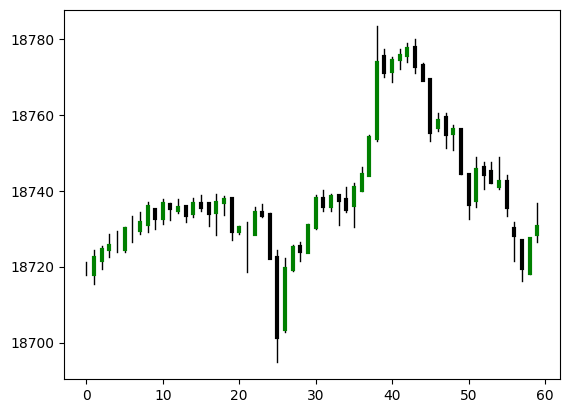

In [21]:
def plot_candles(candles):
    for index in range(len(candles)):
        candle = candles[index]
        c = "green" if candle.c > candle.o else "black"
        plt.plot([index, index], [candle.l, candle.h], linewidth=1, color = "black")
        plt.plot([index, index], [candle.c, candle.o], linewidth=3, color = c)
index+=1
step(index)
plot_candles(m.m1_candles)
if(current_position.direction != 0):
    plt.axhline(current_position.entry, color = "g" if current_position.direction == 1 else "r")
    plt.axhline(current_position.sl, color = "orange")
if(current_order != None):
    plt.axhline(current_order.entry, color = "g" if current_order.direction == 1 else "r")
    plt.axhline(current_order.sl, color = "orange")
print(current_position.direction, equity_L[-1])

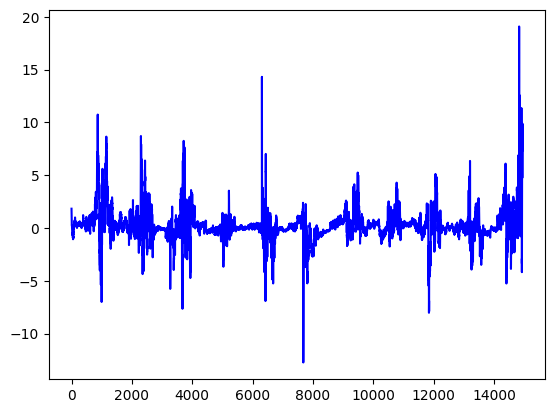

In [22]:
plt.plot([x[1]-x[0] for x in outputs], color="b")

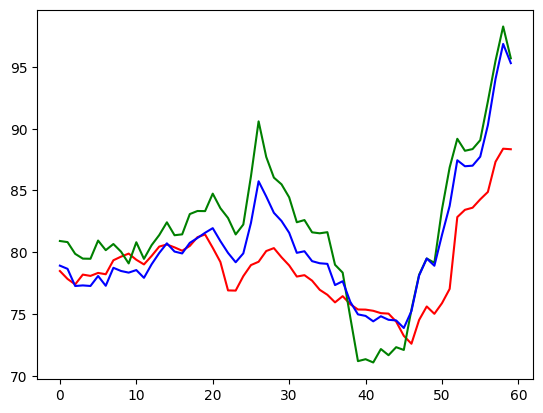

In [23]:
plt.plot([x[0] for x in outputs[-60:]], color="r")
plt.plot([x[1] for x in outputs[-60:]], color="g")
plt.plot([x[2] for x in outputs[-60:]], color="b")

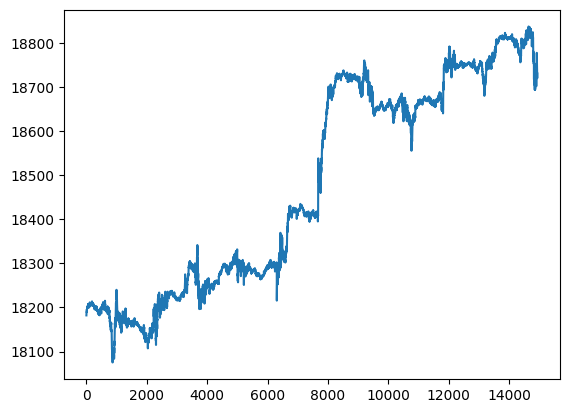

In [24]:
plt.plot([x.c for x in all_candles])

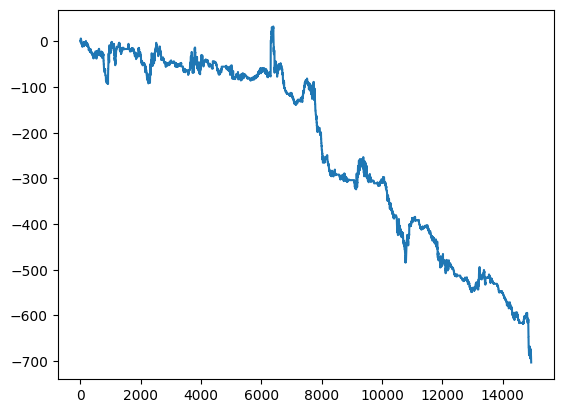

In [25]:
plt.plot(equity_L)

In [ ]:
#exit()